In [2]:
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay, delaunay_plot_2d
import numpy as np
import random
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from scipy import ndimage
import pandas as pd
import pyvoro as voro

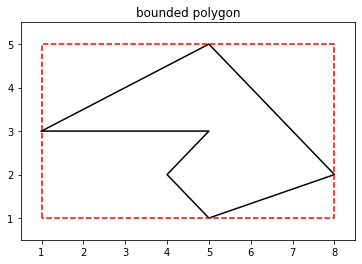

        diam   vol          freq       cfd
0     0.2025  0.00  0.000000e+00  0.000000
1     0.2300  0.10  3.187114e-01  0.318711
2     0.2615  0.18  2.168533e-01  0.535565
3     0.2970  0.27  1.480171e-01  0.683582
4     0.3375  0.39  1.008695e-01  0.784451
5     0.3835  0.52  6.875196e-02  0.853203
6     0.4360  0.67  4.678662e-02  0.899990
7     0.4955  0.82  3.187500e-02  0.931865
8     0.5650  0.97  2.149987e-02  0.953365
9     0.6400  1.11  1.479249e-02  0.968157
10    0.7250  1.25  1.017577e-02  0.978333
11    0.8250  1.39  6.905885e-03  0.985239
12    0.9400  1.51  4.668718e-03  0.989908
13    1.0650  1.63  3.210202e-03  0.993118
14    1.2100  1.75  2.188896e-03  0.995307
15    1.3750  1.86  1.491671e-03  0.996798
16    1.5600  1.98  1.021427e-03  0.997820
17    1.7750  2.09  6.934036e-04  0.998513
18    2.0150  2.20  4.739756e-04  0.998987
19    2.2900  2.31  3.229050e-04  0.999310
20    2.6050  2.40  2.193603e-04  0.999529
21    2.9600  2.49  1.495223e-04  0.999679
22    3.360

In [16]:
polygon = np.array([[1, 3],
       [5, 5],
       [8, 2],
       [5, 1],
       [4, 2],
       [5, 3],
       [1, 3]])

xmin,ymin = min(polygon[:,0]),min(polygon[:,1])
xmax,ymax = max(polygon[:,0]),max(polygon[:,1])


plt.plot(polygon[:,0],polygon[:,1],color = 'black')
plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')
plt.xlim([xmin-0.5,xmax+0.5])
plt.ylim([ymin-0.5,ymax+0.5])
plt.title('bounded polygon')
plt.savefig('1', dpi=300)
plt.show()


size_dist = pd.read_csv('./input.csv',delimiter='\t',names=['diam','vol'])
size_dist['diam'] = size_dist['diam']/10
size_dist['freq'] = size_dist['vol']/(size_dist['vol'] * (size_dist['diam'])**3)
size_dist['freq'] = size_dist['freq']/(size_dist['freq'].sum())
size_dist['freq'] = size_dist['freq'].fillna(0.)
cfd = [size_dist['freq'][0]]
for i,v in enumerate(size_dist['freq'][1:]):
    cfd.append(v+cfd[i])
size_dist['cfd'] = cfd

print(size_dist)

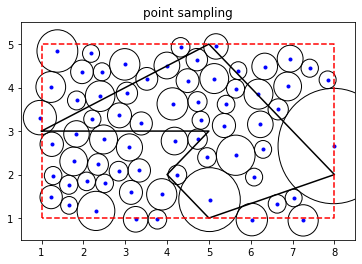

In [15]:
n = 2
r = 0.1
k = 30
rmean = 0.1

xmin,ymin = min(polygon[:,0]),min(polygon[:,1])
xmax,ymax = max(polygon[:,0]),max(polygon[:,1])
width,height = xmax-xmin,ymax-ymin

#step 0
w = r
cols = int(width/w)
rows = int(height/w)

grid = np.array([[None,None,None]]*cols*rows)
active = []

_ =  np.random.random()
i = 0
while _ > size_dist['cfd'][i] and i<len(size_dist['cfd']): i+=1
r_new = size_dist['diam'][i]-((size_dist['cfd'][i]-_)*(size_dist['diam'][i]-size_dist['diam'][i-1]))/(size_dist['cfd'][i]-size_dist['cfd'][i-1])


#step 1
pos = np.random.rand(n+1)*[width,height,r_new]

i = int(pos[0]/w)
j = int(pos[1]/w)
grid[i+j*cols] = pos
active.append(pos)

_ =  np.random.random()
i = 0
while _ > size_dist['cfd'][i] and i<len(size_dist['cfd']): i+=1
r_new = size_dist['diam'][i]-((size_dist['cfd'][i]-_)*(size_dist['diam'][i]-size_dist['diam'][i-1]))/(size_dist['cfd'][i]-size_dist['cfd'][i-1])


#step 2
while len(active) > 0:
    randID = random.randint(0,len(active)-1)
    pos = active[randID]
    found = False
    for i in range(k):
        valid_sample = True
        a = random.random()*2*np.pi
        dist = pos[2]+r_new
        sample = pos +[np.cos(a)*dist,np.sin(a)*dist,r_new-pos[2]]
        col, row = int(sample[0]/w), int(sample[1]/w)
        if(col>-1 and row>-1 and col<cols and row<rows and not grid[col+row*cols][0]):
            for i in range(-20,20):
                for j in range(-20,20):
                    if((col+i)>-1 and (col+i)<cols and (row+j)>-1 and (row+j)<rows):
                        neighbour = grid[(col+i)+(row+j)*cols]    
                        if(neighbour[0] and ((sample[0]-neighbour[0])**2+(sample[1]-neighbour[1])**2)**0.5 < neighbour[2]+r_new):
                            valid_sample = False
            if(valid_sample == True):
                found = True
                grid[col+row*cols] = sample
                active.append(sample)
                _ =  np.random.random()
                i = 0
                while _ > size_dist['cfd'][i] and i<len(size_dist['cfd']): i+=1
                r_new = size_dist['diam'][i]-((size_dist['cfd'][i]-_)*(size_dist['diam'][i]-size_dist['diam'][i-1]))/(size_dist['cfd'][i]-size_dist['cfd'][i-1])
                break
    if(not found):
        active.pop(randID)

points = np.array([i+[xmin,ymin,0] for i in grid if i[0]])

fig, ax = plt.subplots()
for i in points:
    plt.plot(i[0],i[1],'b.')
    particle = plt.Circle((i[0],i[1]), i[2], fill=False)
    ax.add_patch(particle)

plt.plot(polygon[:,0],polygon[:,1],color = 'black')
plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')
plt.xlim([xmin-0.5,xmax+0.5])
plt.ylim([ymin-0.5,ymax+0.5])
plt.title('point sampling')
plt.savefig('2', dpi=300)
plt.show()


In [9]:
with open("./bimodal.txt",'w') as output:
    for i,v in enumerate(points):
        output.write(f'{i} {v[0]} {v[1]} 0.0\n')

with open("./mono.txt",'w') as output:
    for i,v in enumerate(points):
        output.write(f'{i} {v[0]} {v[1]} 0.0 {v[2]}\n')

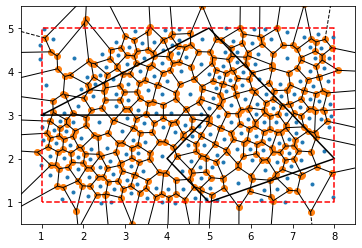

In [138]:
vor = Voronoi(points[:,:2])
voronoi_plot_2d(vor)

plt.plot(polygon[:,0],polygon[:,1],color = 'black')
plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')
plt.xlim([xmin-0.5,xmax+0.5])
plt.ylim([ymin-0.5,ymax+0.5])
plt.show()

(0.5, 5.5)

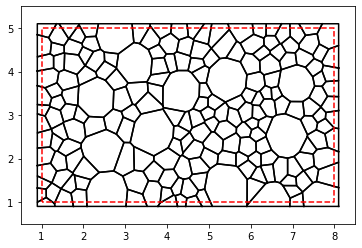

In [4]:
vor = voro.compute_2d_voronoi(
  points[:,:2],
  # points[:,:2].tolist(), # point positions
  [[xmin-0.1,xmax+0.1], [ymin-0.1,ymax+0.1]], # limits
  2.0, # block size
  radii=points[:,2] # particle radii -- optional, and keyword-compatible arg.
)

for i in vor:
    poly = Polygon(i['vertices'])
    x,y = poly.exterior.xy
    plt.plot(x,y,'black')

# plt.plot(polygon[:,0],polygon[:,1],color = 'black')
plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')
plt.xlim([xmin-0.5,xmax+0.5])
plt.ylim([ymin-0.5,ymax+0.5])


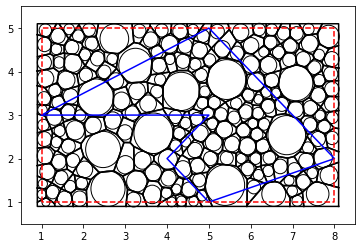

In [5]:
## inscirbe cirtcle in voro++

fig, ax = plt.subplots()

particles = []

for i in vor:
    #find define region and initalise grid of points over it
    reg_verts = np.array(i['vertices'])
    poly = Polygon(i['vertices'])
    centroid = poly.centroid
    xr,yr = max(reg_verts[:,0])-min(reg_verts[:,0]),max(reg_verts[:,1])-min(reg_verts[:,1])
    div = min(xr,yr)/30 # reduce this 25 for massive performace gains but worse accuracy
    #point grid
    x = np.arange(min(reg_verts[:,0])-2*div, max(reg_verts[:,0])+2*div, div)
    y = np.arange(min(reg_verts[:,1])-2*div, max(reg_verts[:,1]+2*div), div)
    nx,ny = len(x),len(y)
    grid = np.ones([nx,ny]) #ones mask
    #apply mask for each face
    for i in range(nx):
        for j in range(ny):
            if poly.contains(Point(x[i],y[j])) == False:
                grid[i,j] = 0
    samples = []
    for i in range(nx):
        for j in range(ny):
            if(grid[i,j] == 1):
                samples.append([x[i],y[j]])
    dt_image = ndimage.distance_transform_edt(grid)
    r = max(dt_image.flatten())
    cent_inscribed = np.where(dt_image == r)
    r = r*div

    cent_inscribed = list(zip(cent_inscribed[0],cent_inscribed[1]))[0]
    inscribed_circle = [x[cent_inscribed[0]], y[cent_inscribed[1]], r]
    particle = plt.Circle((inscribed_circle[0],inscribed_circle[1]), inscribed_circle[2], fill=False, color = 'black')
    ax.add_patch(particle)
    particles.append(inscribed_circle)


for i in vor:
    poly = Polygon(i['vertices'])
    x,y = poly.exterior.xy
    plt.plot(x,y,'black')

plt.plot(polygon[:,0],polygon[:,1],color = 'blue')
plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')

plt.xlim([xmin-0.5,xmax+0.5])
plt.ylim([ymin-0.5,ymax+0.5])
plt.show()

(array([72., 71., 39.,  0.,  0.,  0.,  0.,  2.,  6.,  5.]),
 array([0.1011661564812591, 0.14010954536555834, 0.17905293424985758,
        0.21799632313415682, 0.25693971201845606, 0.29588310090275527,
        0.33482648978705454, 0.37376987867135375, 0.412713267555653,
        0.4516566564399523, 0.4906000453242515], dtype=object),
 <BarContainer object of 10 artists>)

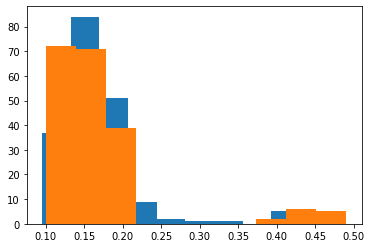

In [26]:
sum = 0
for i in particles:
    sum += np.pi*i[2]**2

sum/(7*4)

#random close packing 2D = 85%
#3D =64%

plt.hist(np.array(particles)[:,2])
plt.hist(np.array(points)[:,2])

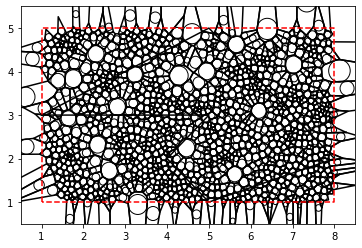

In [50]:
fig, ax = plt.subplots()

regions = []
vertices = vor.vertices
for i in vor.regions:
    if i and -1 not in i:
        regions.append(i)

# for i in regions:
#     poly = Polygon(np.array([vertices[j] for j in i]))
#     x,y = poly.exterior.xy
#     plt.plot(x,y,'b--')

particles = []

for i,region in enumerate(regions):
    #find define region and initalise grid of points over it
    reg_verts = []
    centroid = np.array([0.0,0.0])
    for i,v in enumerate(vertices):
        if i in region:
            reg_verts.append(v)
            centroid += v
    reg_verts = np.array(reg_verts)
    centroid /= len(reg_verts)
    #break out if centroi outside bounding box
    # if centroid[0] < xmin or centroid[0] > xmax or centroid[1] < ymin or centroid[1] > ymax:
    #     break
    xr,yr = max(reg_verts[:,0])-min(reg_verts[:,0]),max(reg_verts[:,1])-min(reg_verts[:,1])
    div = min(xr,yr)/30 # reduce this 25 for massive performace gains but worse accuracy
    #point grid
    x = np.arange(min(reg_verts[:,0])-div, max(reg_verts[:,0])+div, div)
    y = np.arange(min(reg_verts[:,1])-div, max(reg_verts[:,1]+div), div)
    nx,ny = len(x),len(y)
    grid = np.ones([nx,ny]) #ones mask
    #apply mask for each face
    poly = Polygon(np.array([vertices[i] for i in region]))
    for i in range(nx):
        for j in range(ny):
            if poly.contains(Point(x[i],y[j])) == False:
                grid[i,j] = 0
    samples = []
    for i in range(nx):
        for j in range(ny):
            if(grid[i,j] == 1):
                samples.append([x[i],y[j]])
    dt_image = ndimage.distance_transform_edt(grid)
    r = max(dt_image.flatten())
    cent_inscribed = np.where(dt_image == r)
    r = r*div

    cent_inscribed = list(zip(cent_inscribed[0],cent_inscribed[1]))[0]
    inscribed_circle = [x[cent_inscribed[0]], y[cent_inscribed[1]], r]
    particle = plt.Circle((inscribed_circle[0],inscribed_circle[1]), inscribed_circle[2], fill=False, color = 'black')
    ax.add_patch(particle)
    particles.append(inscribed_circle)

for i in regions:
    poly = Polygon(np.array([vertices[j] for j in i]))
    x,y = poly.exterior.xy
    plt.plot(x,y,'black')

plt.plot(polygon[:,0],polygon[:,1],color = 'black')
plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')

plt.xlim([xmin-0.5,xmax+0.5])
plt.ylim([ymin-0.5,ymax+0.5])
plt.show()

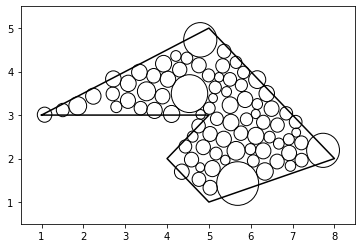

In [141]:
def trim(particles):
    shell = Polygon(polygon)
    particles = np.array([i for i in particles if shell.contains(Point(i[:2]))])

    fig, ax = plt.subplots()
    for i in particles:
        particle = plt.Circle((i[0],i[1]), i[2], fill=False, color = 'black')
        ax.add_patch(particle)

    plt.plot(polygon[:,0],polygon[:,1],color = 'black')
    # plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')

    plt.xlim([xmin-0.5,xmax+0.5])
    plt.ylim([ymin-0.5,ymax+0.5])
    plt.show()
trim(particles)

TypeError: list indices must be integers or slices, not tuple

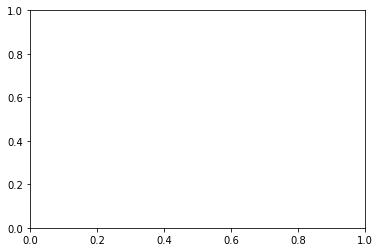

In [52]:
fig, ax = plt.subplots()
for i in particles:
    particle = plt.Circle((i[0],i[1]), i[2], fill=False, color = 'black')
    ax.add_patch(particle)

delan = Delaunay(np.array(particles)[:,:2])
# delaunay_plot_2d(delan)

simps = []
for i in delan.simplices:
    for j,v in enumerate(i):
        for k in i[j+1:]:
            if ((particles[v][0]-particles[k][0])**2 + (particles[v][1]-particles[k][1])**2)**0.5 < 0.2:
                simps.append([particles[v][:2],particles[k][:2]])


simps = [i for i in delan.simplices if shell.contains(Polygon([particles[i[0],:2],particles[i[1],:2],particles[i[2],:2]])) == True]
plt.triplot(particles[:,0], particles[:,1],simps,color = 'r')

# print(delan.vertices)

plt.xlim([xmin-0.5,xmax+0.5])
plt.ylim([ymin-0.5,ymax+0.5])
plt.show()
connectivity(particles)

TypeError: list indices must be integers or slices, not tuple

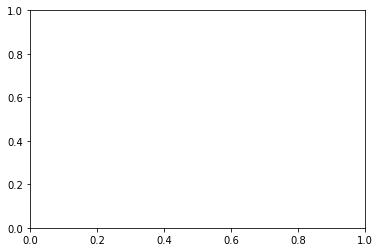

In [117]:
def connect(particles):
    shell = Polygon(polygon)
    fig, ax = plt.subplots()
    delan = Delaunay(np.array(particles)[:,:2])
    # delaunay_plot_2d(delan)

    simps = []
    for i in delan.simplices:
        for j,v in enumerate(i):
            for k in i[j+1:]:
                if ((particles[v][0]-particles[k][0])**2 + (particles[v][1]-particles[k][1])**2)**0.5 < 0.2:
                    simps.append([particles[v][:2],particles[k][:2]])


    simps = [i for i in delan.simplices if shell.contains(Polygon([particles[i[0],:2],particles[i[1],:2],particles[i[2],:2]])) == True]
    plt.triplot(particles[:,0], particles[:,1],simps,color = 'r')

    # print(delan.vertices)

    particles = np.array([i for i in particles if shell.contains(Point(i[:2]))])

    for i in particles:
        particle = plt.Circle((i[0],i[1]), i[2], fill=False, color = 'black')
        ax.add_patch(particle)

    # plt.plot(polygon[:,0],polygon[:,1],color = 'black')
    # # plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')

    plt.xlim([xmin-0.5,xmax+0.5])
    plt.ylim([ymin-0.5,ymax+0.5])
    plt.show()
connect(particles)

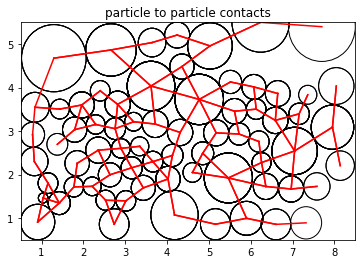

In [118]:
def connectivity(particles_):
    conect = []

    delan = Delaunay(np.array(particles_)[:,:2])

    simps_ = []
    for i in delan.simplices:
        for j,v in enumerate(i):
            for w in i[j+1:]:
                if ((particles_[v][0]-particles_[w][0])**2 + (particles_[v][1]-particles_[w][1])**2)**0.5 <= (particles_[v][2]+particles_[w][2])*1.1:
                    conect.append(particles_[v])
                    conect.append(particles_[w])
                    simps_.append([particles_[v][:2],particles_[w][:2]])

    # for i in simps_:
    #     print(i)

    fig, ax = plt.subplots()
    for i in conect:
        particle = plt.Circle((i[0],i[1]), i[2], fill=False, color = 'black')
        ax.add_patch(particle)

    for i in simps_:
        plt.plot([i[0][0],i[1][0]],[i[0][1],i[1][1]],'r')
    
    plt.xlim([xmin-0.5,xmax+0.5])
    plt.ylim([ymin-0.5,ymax+0.5])
    plt.title('particle to particle contacts')
    plt.savefig('p-p_contacts', dpi=300)
    plt.show()

connectivity(particles)

In [52]:
import numpy as np
grid = np.random.randint(0,2,[10,10])

for i in range(1,9):
    for j in range(1,9):
        print(grid[i][j])

# next_to = lambda



array([[0, 1, 1, 0, 0, 1, 0, 0, 1, 1],
       [1, 0, 0, 1, 0, 1, 1, 1, 0, 0],
       [1, 1, 0, 1, 1, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 1, 1, 0, 0, 1, 0],
       [0, 0, 1, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 0, 0, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 0, 1, 1],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 1, 1, 1, 1]])